In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob

In [83]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client
# Setup your PBSCluster

project = 'P93300641' #input your project code

cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='25GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB', # Specify resources
    project=project, # Input your project ID here
    walltime='02:45:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(25)

# Setup your client
client = Client(cluster)

/glade/work/djk2120/miniconda3/envs/trendy-py/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42376 instead
  f"Port {expected} is already in use.\n"


In [84]:
client.cluster

In [4]:
dvs=['TBOT','FSDS','NBP']
def preprocess(ds):
    return ds[dvs]

In [38]:
dirs=['/glade/scratch/djk2120/archive/TRENDY2022_f09_'+exp+'/lnd/hist/' for exp in ['S1','S2','S3']]
s0='/glade/campaign/asp/djk2120/trendy2022/S0/lnd/hist/'
dirs=[s0,*dirs]

In [39]:
dirs

['/glade/campaign/asp/djk2120/trendy2022/S0/lnd/hist/',
 '/glade/scratch/djk2120/archive/TRENDY2022_f09_S1/lnd/hist/',
 '/glade/scratch/djk2120/archive/TRENDY2022_f09_S2/lnd/hist/',
 '/glade/scratch/djk2120/archive/TRENDY2022_f09_S3/lnd/hist/']

In [50]:
dsets={}
for d in dirs:
    exp=d.split('/')[-4][-2:]
    print(exp)
    files = sorted(glob.glob(d+'*.h0.*'))
    ds=xr.open_mfdataset(files,combine='nested',concat_dim='time',parallel=True,preprocess=preprocess)
    ds['time']=xr.cftime_range(str(1701),periods=len(ds.time),freq='MS')
    dsets[exp]=ds

S0
S1
S2
S3


In [55]:
for exp in dsets:
    ds=dsets[exp]
    dpm = ds.time.dt.days_in_month
    nbp[exp]=cf*(dpm*la*ds.NBP).sum(dim=['lat','lon']).groupby('time.year').sum().compute()

In [69]:
exp='S0'
ds=dsets['S0']
dpm= ds.time.dt.days_in_month
s0=cf*(dpm*la*ds.NBP).sum(dim=['lat','lon']).groupby('time.year').sum().compute()

In [71]:
exp='S1'
ds=dsets[exp]
dpm= ds.time.dt.days_in_month
s1=cf*(dpm*la*ds.NBP).sum(dim=['lat','lon']).groupby('time.year').sum().compute()

In [104]:
files=sorted(glob.glob(dirs[3]+'*.h0.*'))

In [105]:
def preprocess(ds):
    return ds['PCO2']
ds=xr.open_mfdataset(files,combine='nested',concat_dim='time',parallel=True,preprocess=preprocess)

In [106]:
co3=ds.max(dim=['lat','lon']).compute()

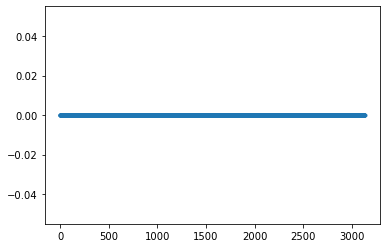

In [109]:
plt.plot(co3-co2,'.')

In [115]:
t

2022.0

In [118]:
len(c)

3852

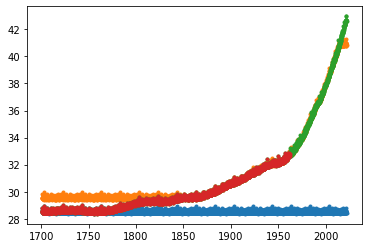

In [123]:
for c in [co0,co1,co2,co3]:
    t=1701+np.arange(len(c))/12
    plt.plot(t,c,'.')


In [94]:
files=sorted(glob.glob(dirs[0]+'*.h0.*'))

In [95]:
def preprocess(ds):
    return ds['PCO2']
ds=xr.open_mfdataset(files,combine='nested',concat_dim='time',parallel=True,preprocess=preprocess)

In [96]:
co0=ds.max(dim=['lat','lon']).compute()

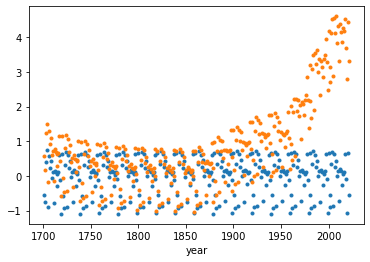

In [74]:
s0.plot.line('.')
s1.plot.line('.')


In [13]:
tmp = xr.open_dataset(files[0])
la = tmp.area*tmp.landfrac
dpm = ds.time.dt.days_in_month

In [27]:
nbp=cf*(dpm*la*ds.NBP).sum(dim=['lat','lon']).groupby('time.year').sum().compute()

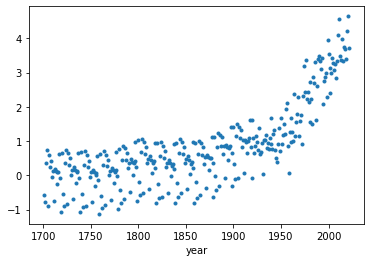

In [29]:
nbp.plot.line('.')

In [4]:
dvs=['TOTVEGC','TOTECOSYSC','GPP','NPP','TOTSOMC','TWS']
d='/glade/scratch/djk2120/archive/TRENDY2022_f09_spinPostAD/lnd/hist/'
f1=sorted(glob.glob(d+'*h0*nc'))
f2=[]
#d='/glade/scratch/djk2120/TRENDY2022_f09_spinPostAD/run/'
#f2=sorted(glob.glob(d+'*spinPostAD.clm2.h0.*'))[:-1]

In [5]:
def preprocess(ds):
    return ds[dvs]
ds=xr.open_mfdataset([*f1,*f2],combine='nested',concat_dim='time',parallel=True,preprocess=preprocess)

In [6]:
tmp = xr.open_dataset(f1[0])
la = tmp.area*tmp.landfrac

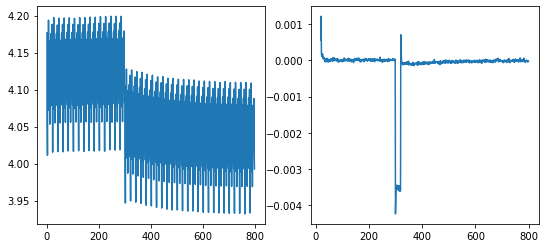

In [7]:
v='NPP'
cf=1e-9*24*60*60*30
nt = len(ds.time)
ix = np.arange(nt)>0
x=cf*(la*ds[v]).isel(time=ix).sum(dim=['lat','lon']).compute()
plt.figure(figsize=[9,4])
plt.subplot(121)
plt.plot(x)
plt.subplot(122)
plt.plot(20+np.arange(nt-21),(x[20:].values-x[:-20].values)/20)
#plt.xlim([300,400])

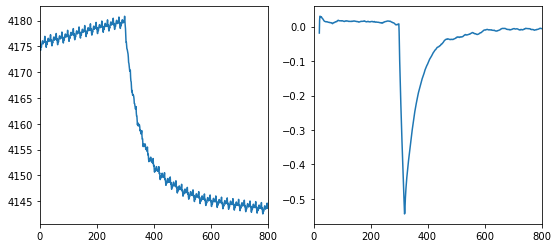

In [8]:
v='TOTECOSYSC'
nt = len(ds.time)
ix = np.arange(nt)>0

#cf=1e-9*24*60*60*30
cf=1e-9
x=cf*(la*ds[v]).isel(time=ix).sum(dim=['lat','lon']).compute()

plt.figure(figsize=[9,4])
plt.subplot(121)
plt.plot(x)
plt.xlim([0,nt])
plt.subplot(122)
plt.plot(20+np.arange(nt-21),(x[20:].values-x[:-20].values)/20)

plt.xlim([0,nt]);

In [9]:
drift = np.mean(x[-40:-20].values-x[-20:].values)/20
drift

0.006853027641773224

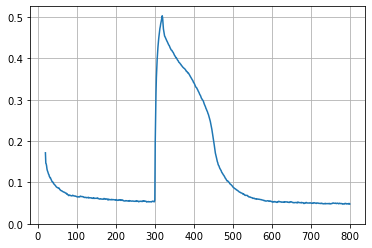

In [10]:
cf=1
x=cf*ds[v][1:,:,:]
nt = len(x)-20
x1=x.shift(time=20)[20:,:,:]
x2=x[20:,:,:]
diseq=(la*(abs(x2-x1)>20)).sum(dim=['lat','lon'])/la.sum()
plt.plot(20+np.arange(nt),diseq)
#plt.xlim([0,600])
plt.ylim(bottom=0)
plt.grid()

In [11]:
diseq[-1].values

array(0.04781818, dtype=float32)

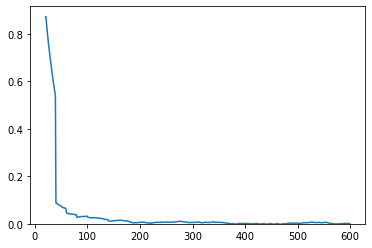

In [34]:
v='TOTVEGC'
nt = len(ds.time)
ix = np.arange(nt)>0

cf=1e-9
x=cf*(la*ds[v]).isel(time=ix).sum(dim=['lat','lon']).compute()
plt.plot(20+np.arange(nt-21),(x[20:].values-x[:-20].values)/20)
plt.ylim(bottom=0);

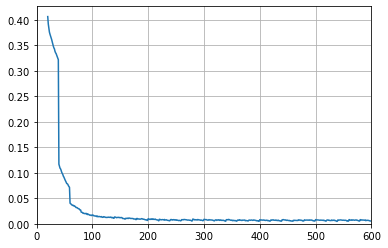

In [36]:
cf=1
x=cf*ds[v][1:,:,:]
nt = len(x)-20
x1=x.shift(time=20)[20:,:,:]
x2=x[20:,:,:]
diseq=(la*(abs(x2-x1)>60)).sum(dim=['lat','lon'])/la.sum()
plt.plot(20+np.arange(nt),diseq)
plt.xlim([0,600])
plt.ylim(bottom=0)
plt.grid()